In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pywt
from scipy.fft import fft

In [8]:
df.head()

NameError: name 'df' is not defined

In [4]:

def replace_outlier_with_previous_day(df, stock_name, outlier_date_str):
    # Convert outlier_date to datetime
    outlier_date = pd.to_datetime(outlier_date_str)
    
    # Find the previous day's price
    previous_day = outlier_date - pd.Timedelta(days=1)
    previous_day_price = df[(df['Stock_Name'] == stock_name) & (df['Date'] == previous_day)]['Price'].values[0]
    
    # Replace the outlier value with the previous day's price
    df.loc[(df['Date'] == outlier_date) & (df['Stock_Name'] == stock_name), 'Price'] = previous_day_price

# Replace the outliers for AAPL and GAS with the previous day's price
replace_outlier_with_previous_day(df, 'AAPL', '2016-02-27')
replace_outlier_with_previous_day(df, 'GAS', '2016-02-27')

# Verify the replacement
print(df[(df['Date'] == '2016-02-27') & (df['Stock_Name'].isin(['AAPL', 'GAS']))])

# Get a list of unique stock names
stocks = df['Stock_Name'].unique()


            Date  Price Stock_Name
2638  2016-02-27  24.23       AAPL
16210 2016-02-27  24.23        GAS


In [5]:
# Calculate statistical metrics
stats = df.groupby('Stock_Name')['Price'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

# Print statistical metrics
print(stats)

# Save statistical metrics to CSV
stats.to_csv('stock_statistics.csv', index=False)

  Stock_Name          mean     median           std       min        max
0        AAA  12393.806349  12100.000   4084.828609   5087.60   22800.00
1       AAPL     88.441504     56.125     58.390842     22.59     198.11
2        ACB  14240.263814  11825.000   7542.813441   3989.40   30360.00
3        BID  27197.631633  28786.150  11105.064057   8197.00   54400.00
4        CTG  20362.424702  17856.900   7578.136319   9134.30   41141.30
5        FPT  42617.300978  30213.950  29635.634579  11722.70  142000.00
6        GAS     88.441504     56.125     58.390842     22.59     198.11
7       NVDA    143.693526     61.825    191.598394      4.78    1224.40
8        VCB  54441.012755  57586.500  23195.090951  16822.00   97400.00
9        VNM  95519.729549  94612.300  24704.238341  58115.30  175578.00


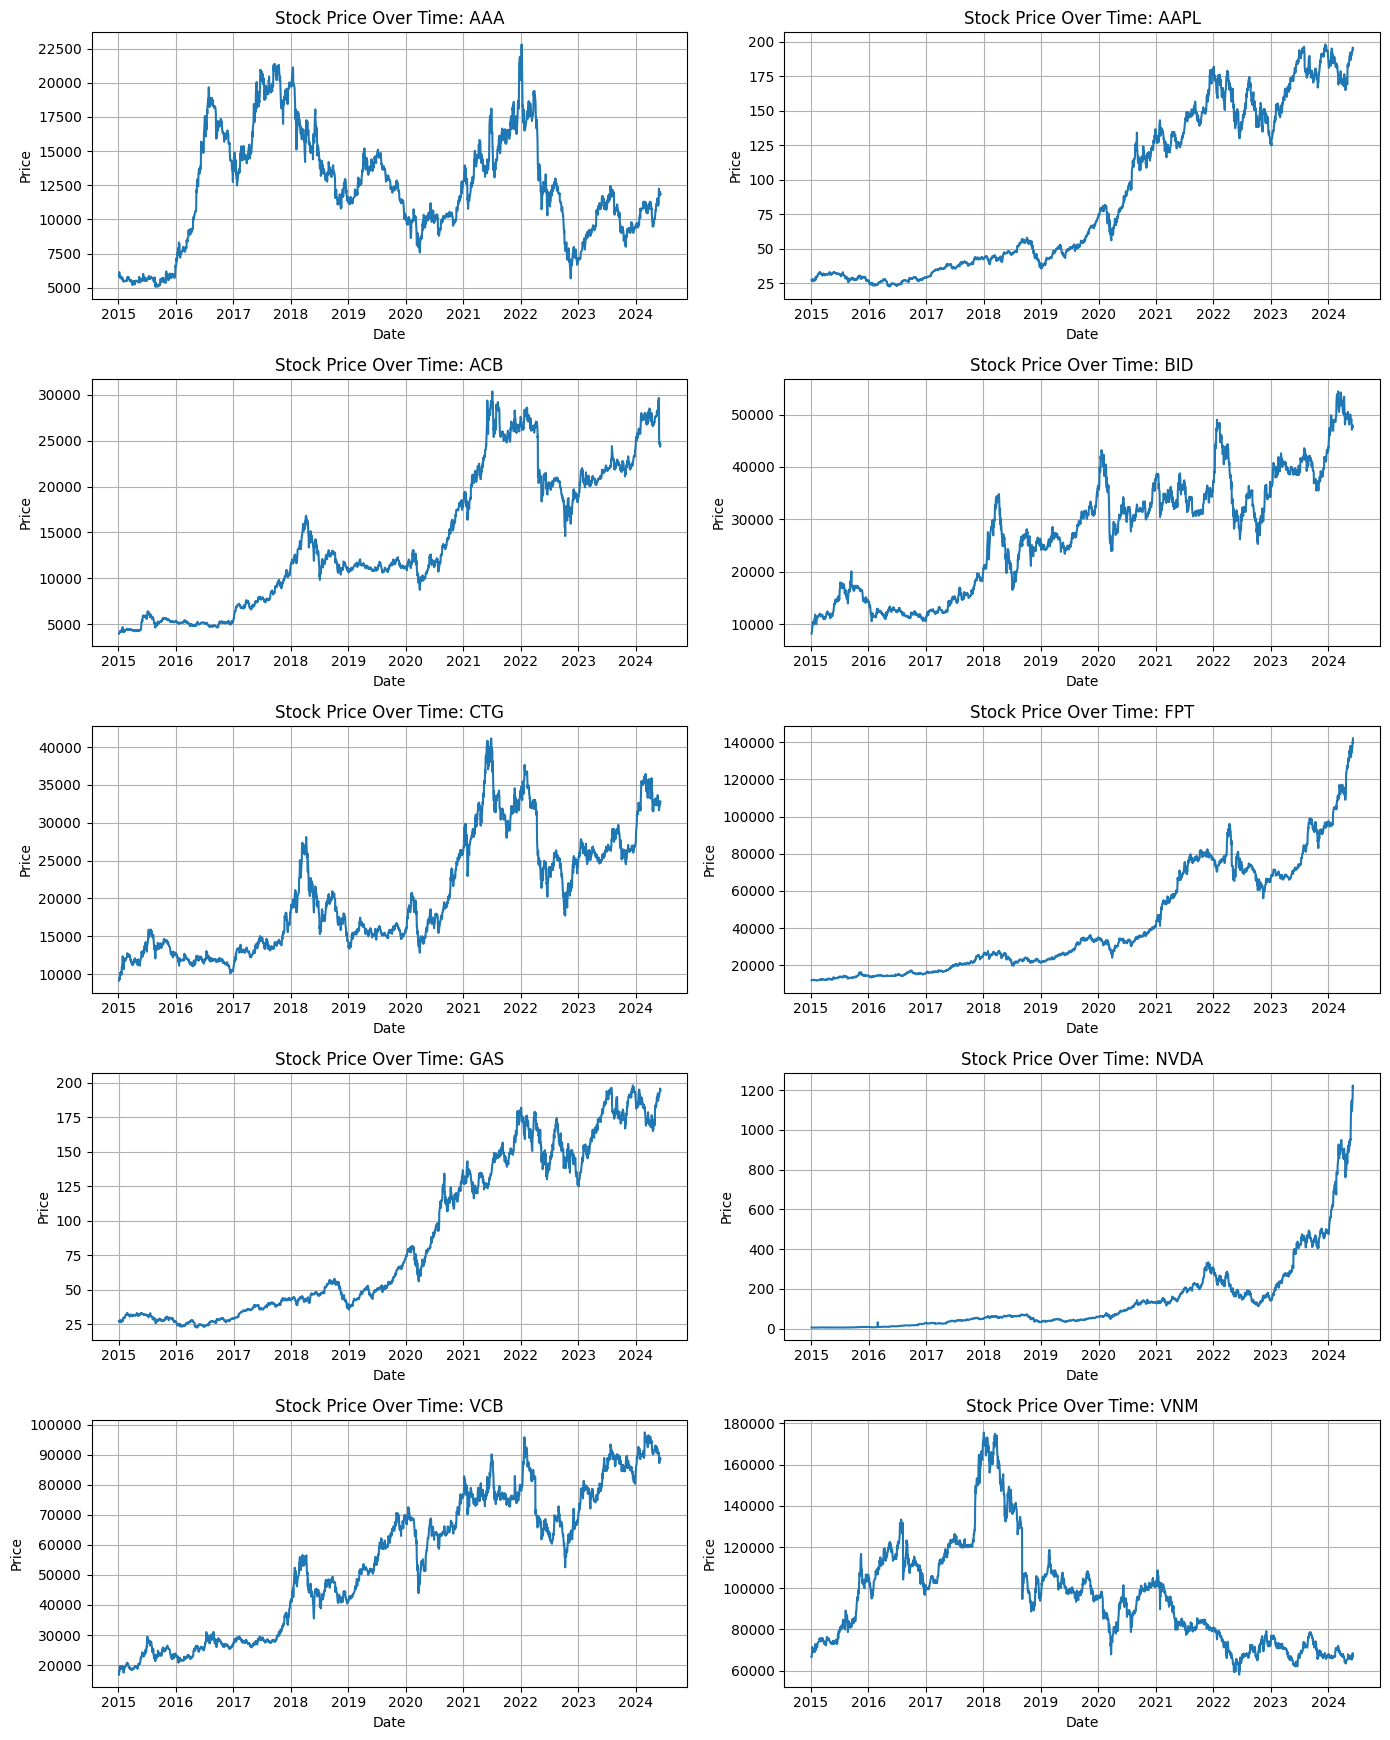

In [6]:
# Determine the number of rows needed (2 plots per row)
num_rows = len(stocks) // 2 + len(stocks) % 2

# Create the subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 3.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each stock in a subplot
for i, stock in enumerate(stocks):
    stock_data = df[df['Stock_Name'] == stock]
    sns.lineplot(x='Date', y='Price', data=stock_data, ax=axes[i])
    axes[i].set_title(f'Stock Price Over Time: {stock}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

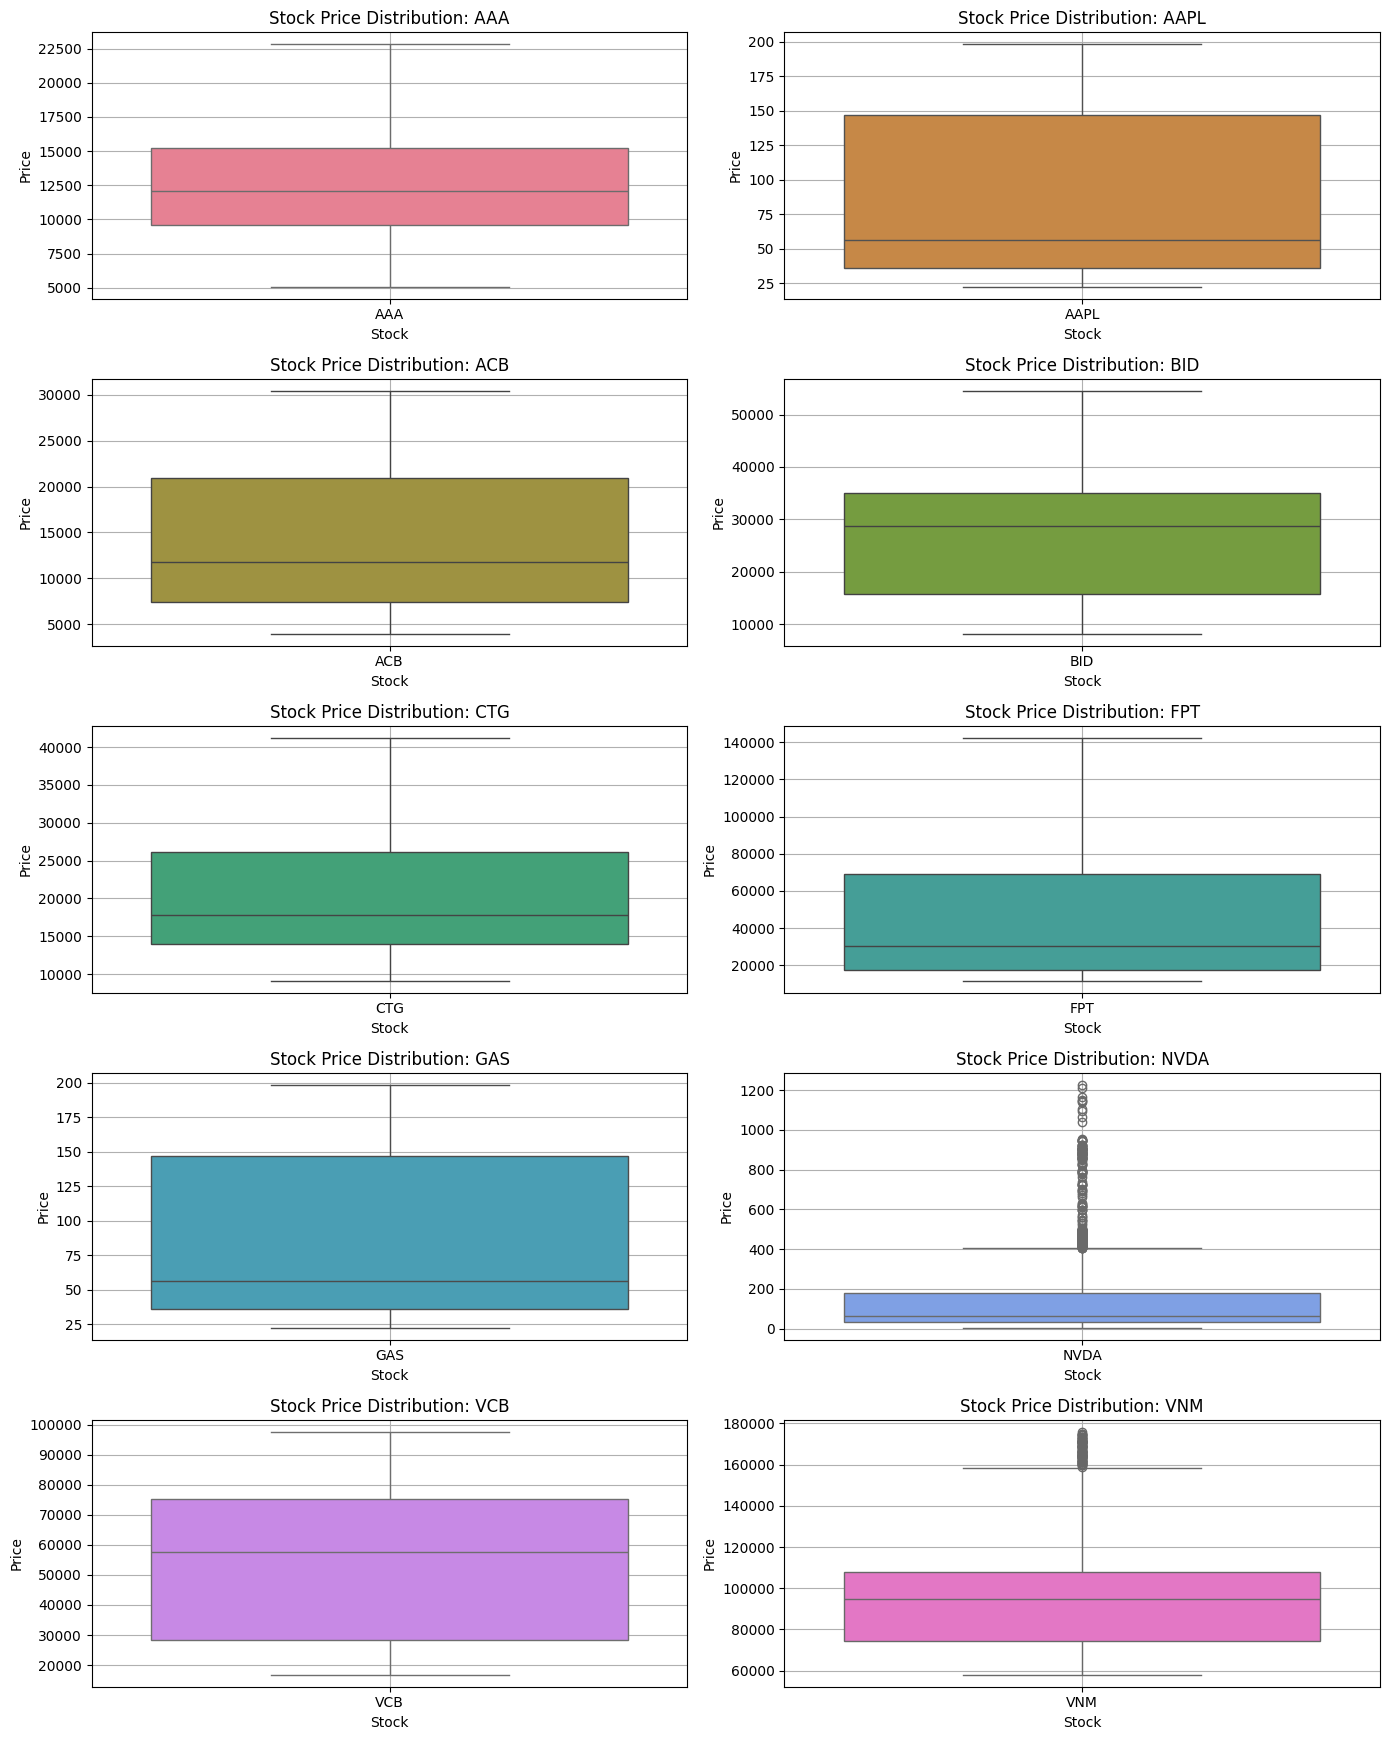

In [7]:
# Determine the number of rows needed (2 plots per row)
num_rows = len(stocks) // 2 + len(stocks) % 2

# Create the subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 3.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each stock in a subplot using box plot with different colors
palette = sns.color_palette("husl", len(stocks))

for i, (stock, color) in enumerate(zip(stocks, palette)):
    stock_data = df[df['Stock_Name'] == stock]
    sns.boxplot(x='Stock_Name', y='Price', data=stock_data, ax=axes[i], color=color)
    axes[i].set_title(f'Stock Price Distribution: {stock}')
    axes[i].set_xlabel('Stock')
    axes[i].set_ylabel('Price')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

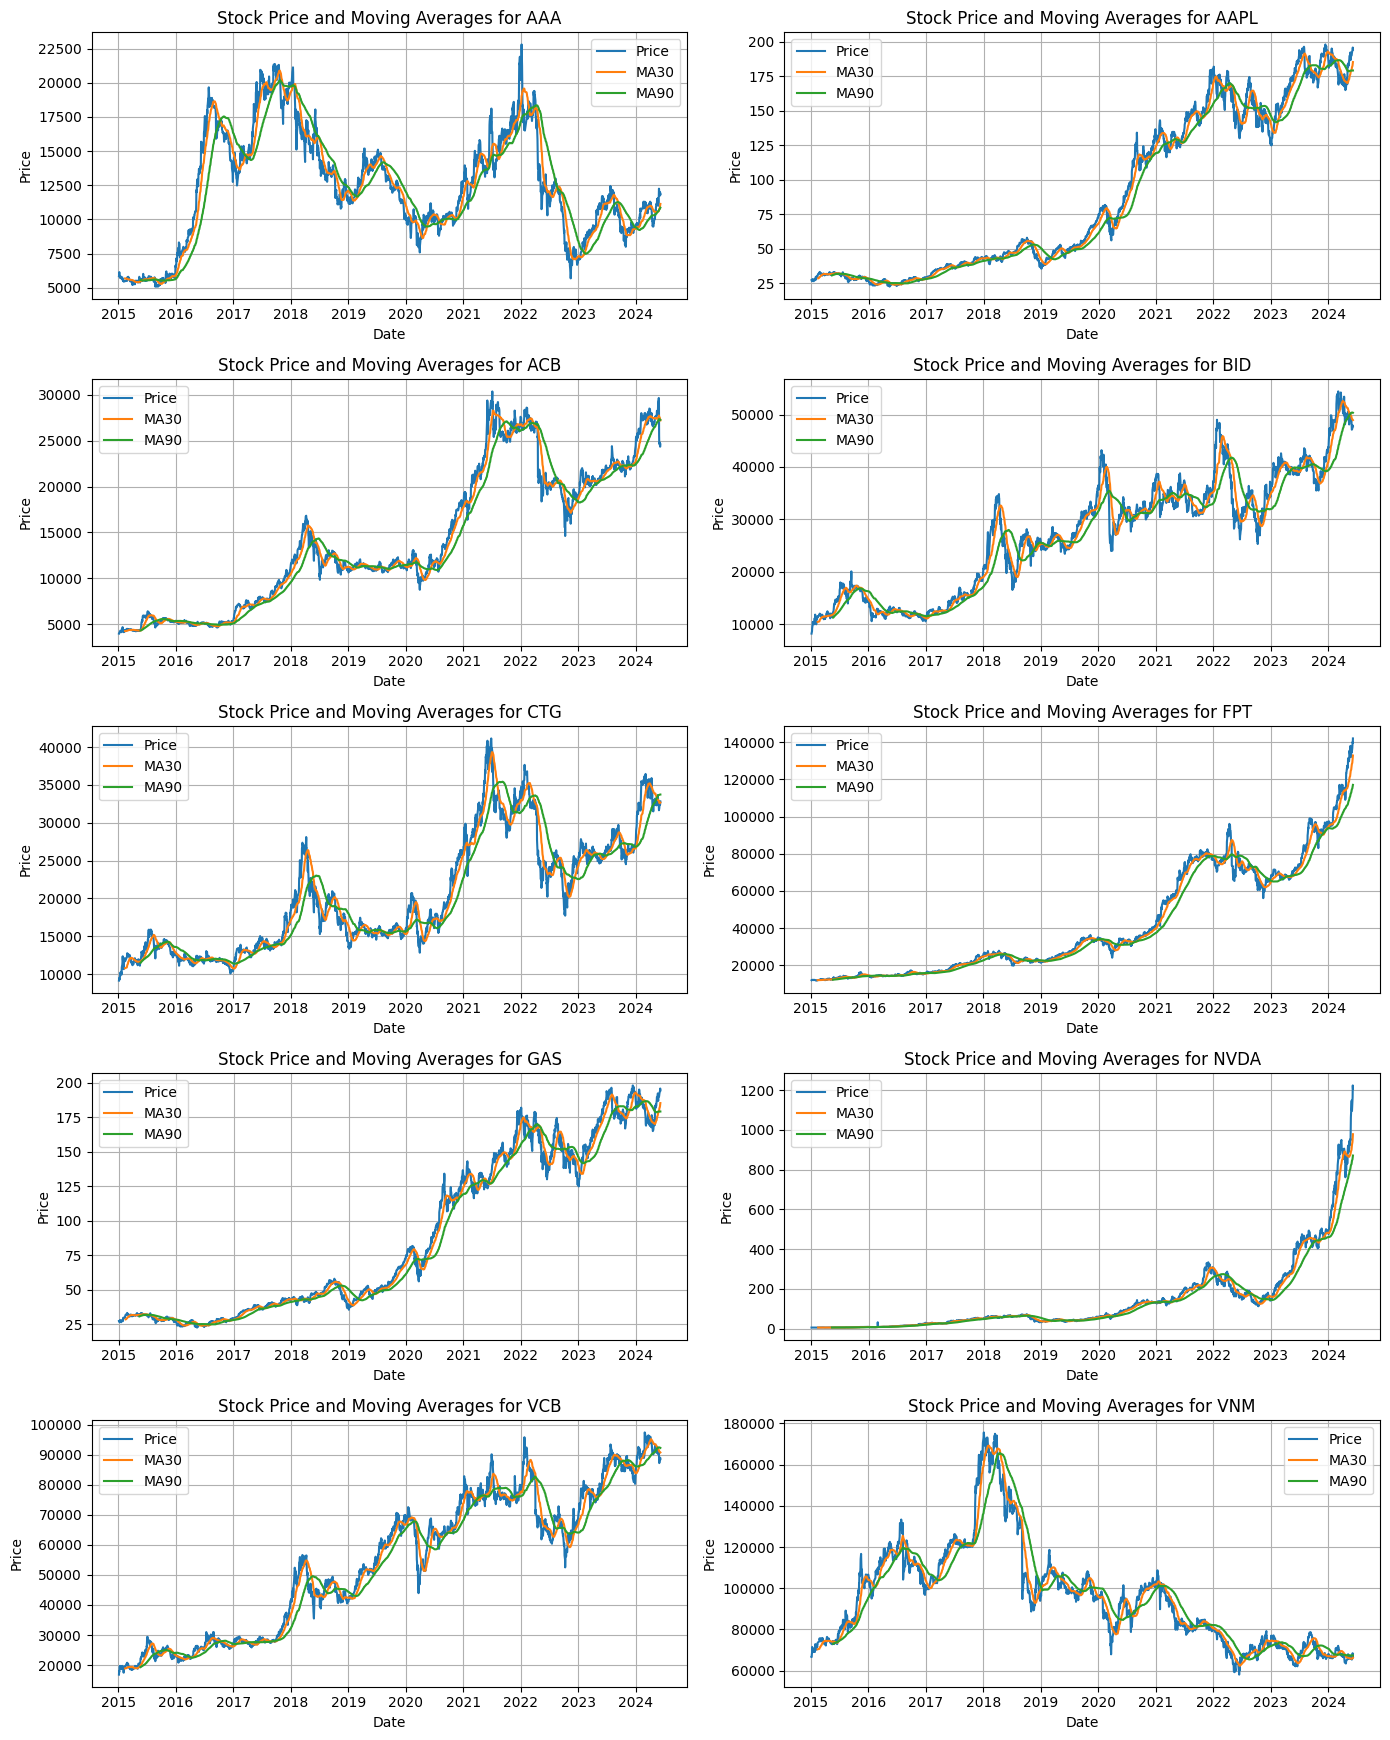

In [8]:
# Determine the number of rows needed (2 plots per row)
num_rows = len(stocks) // 2 + len(stocks) % 2

# Create the subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 3.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each stock in a subplot using MA30 and MA90
for i, stock in enumerate(stocks):
    stock_data = df[df['Stock_Name'] == stock].copy()
    stock_data.set_index('Date', inplace=True)
    
    # Calculate MA30 and MA90
    stock_data['MA30'] = stock_data['Price'].rolling(window=30).mean()
    stock_data['MA90'] = stock_data['Price'].rolling(window=90).mean()
    
    # Plot the stock prices along with MA30 and MA90
    axes[i].plot(stock_data.index, stock_data['Price'], label='Price')
    axes[i].plot(stock_data.index, stock_data['MA30'], label='MA30')
    axes[i].plot(stock_data.index, stock_data['MA90'], label='MA90')
    axes[i].set_title(f'Stock Price and Moving Averages for {stock}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
# Function to test stationarity and return the results as a string
def test_stationarity(timeseries, stock_name):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    result_str = f"Results of Dickey-Fuller Test for {stock_name}:\n{dfoutput.to_string()}\n"
    return result_str

# File path to save the results
output_file_path = 'D:\\Github anyud\\final\\Data_stock\\ADF_results.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    # Test stationarity of the 'Price' column for each stock and write results to the file
    for stock in df['Stock_Name'].unique():
        print(f'\nStationarity test for {stock}:')
        stock_data = df[df['Stock_Name'] == stock]
        result_str = test_stationarity(stock_data['Price'], stock)
        file.write(result_str + '\n')

# Print a message indicating that the results have been saved
print(f'Results have been saved to {output_file_path}')


Stationarity test for AAA:

Stationarity test for AAPL:

Stationarity test for ACB:

Stationarity test for BID:

Stationarity test for CTG:

Stationarity test for FPT:

Stationarity test for GAS:

Stationarity test for NVDA:

Stationarity test for VCB:

Stationarity test for VNM:
Results have been saved to D:\Github anyud\final\Data_stock\ADF_results.txt


In [10]:
# File path to save the results
output_file_path = 'D:\\Github anyud\\final\\Data_stock\\ADF_results_differencing.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    # Test stationarity of the differenced 'Price' column for each stock and write results to the file
    for stock in df['Stock_Name'].unique():
        print(f'\nApplying differencing and stationarity test for {stock}:')
        stock_data = df[df['Stock_Name'] == stock].copy()
        stock_data.set_index('Date', inplace=True)
        
        # Apply differencing
        stock_data['Price_diff'] = stock_data['Price'].diff().dropna()
        
        # Check stationarity
        result_str = test_stationarity(stock_data['Price_diff'].dropna(), stock + ' (Differenced)')
        file.write(result_str + '\n')

# Print a message indicating that the results have been saved
print(f'Results have been saved to {output_file_path}')


Applying differencing and stationarity test for AAA:

Applying differencing and stationarity test for AAPL:

Applying differencing and stationarity test for ACB:

Applying differencing and stationarity test for BID:

Applying differencing and stationarity test for CTG:

Applying differencing and stationarity test for FPT:

Applying differencing and stationarity test for GAS:

Applying differencing and stationarity test for NVDA:

Applying differencing and stationarity test for VCB:

Applying differencing and stationarity test for VNM:
Results have been saved to D:\Github anyud\final\Data_stock\ADF_results_differencing.txt


C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


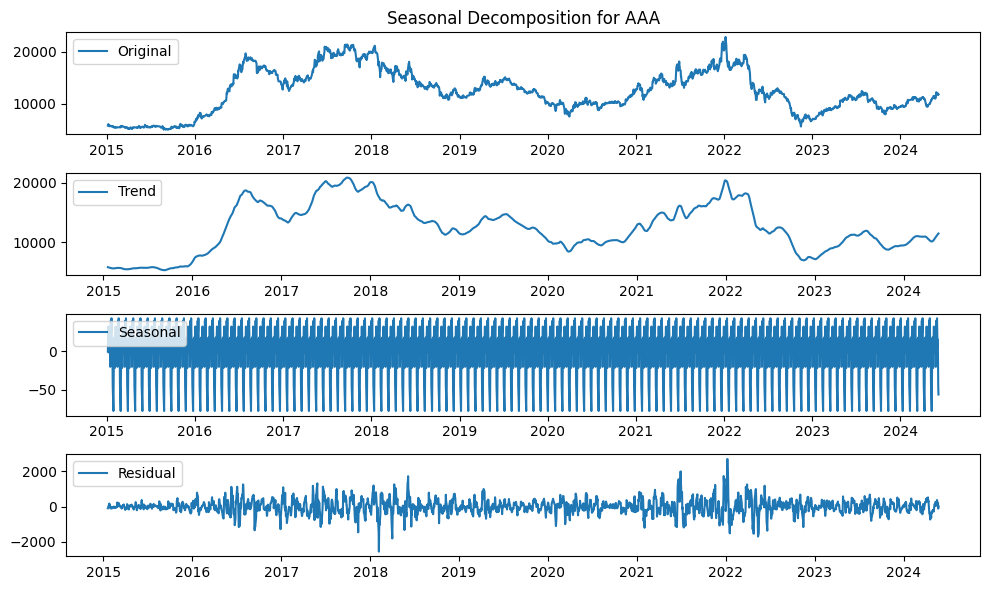

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


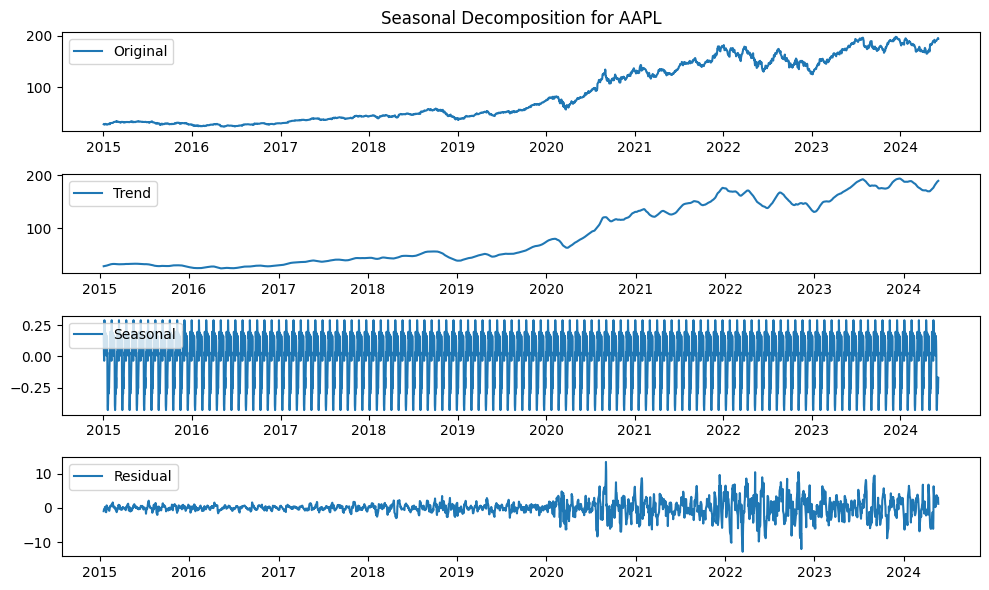

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


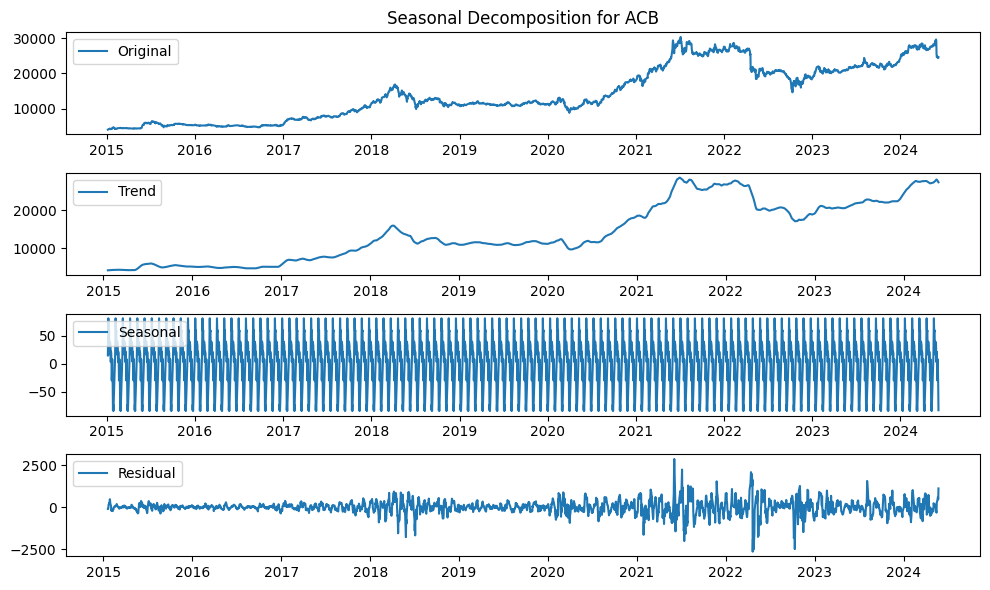

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


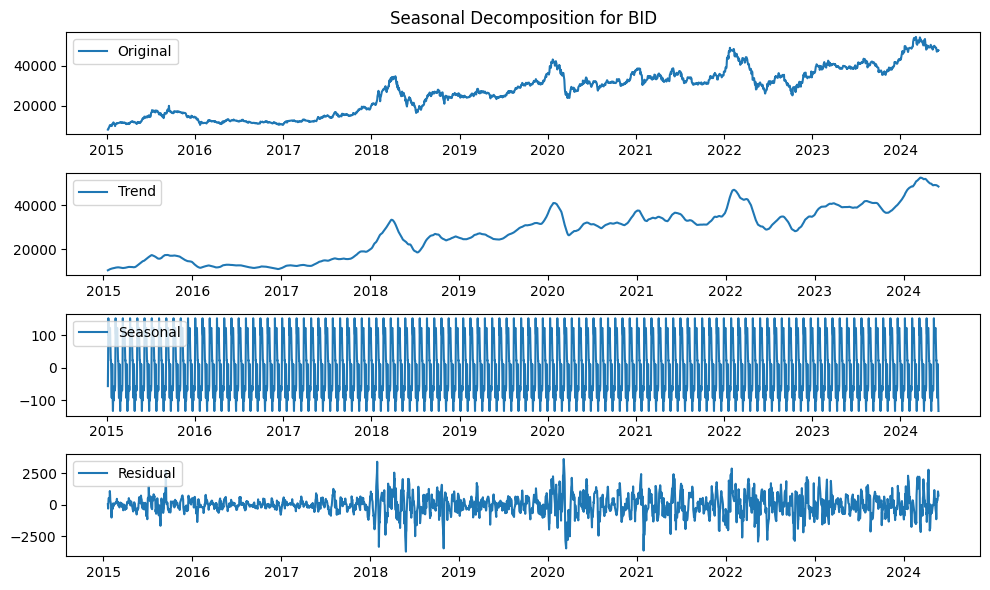

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


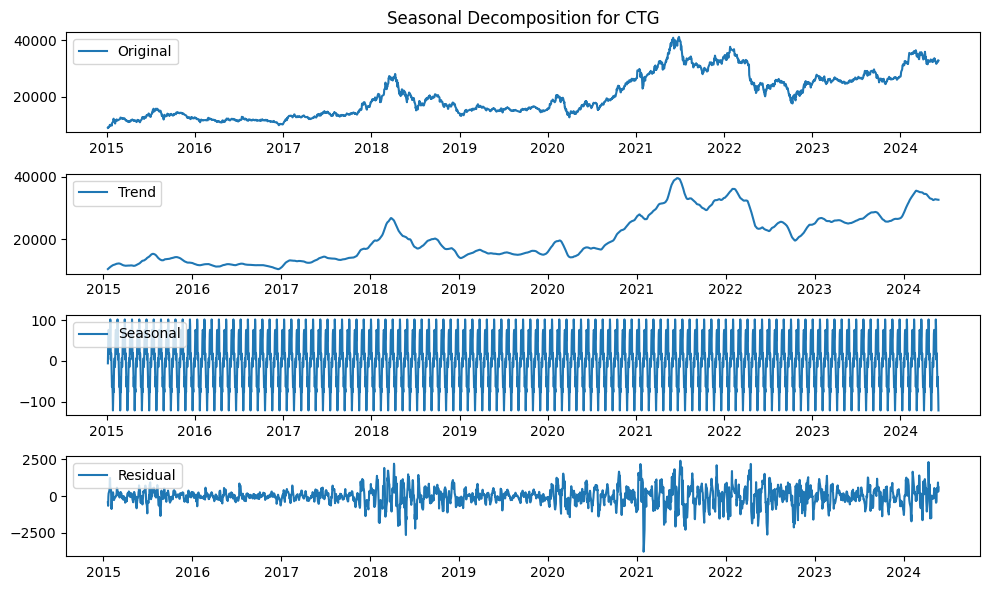

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


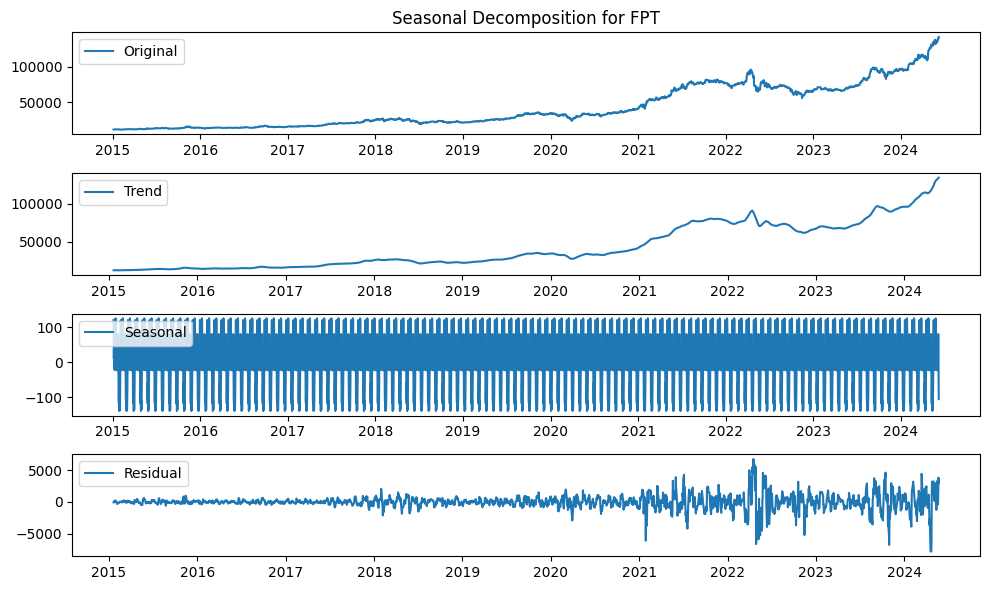

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


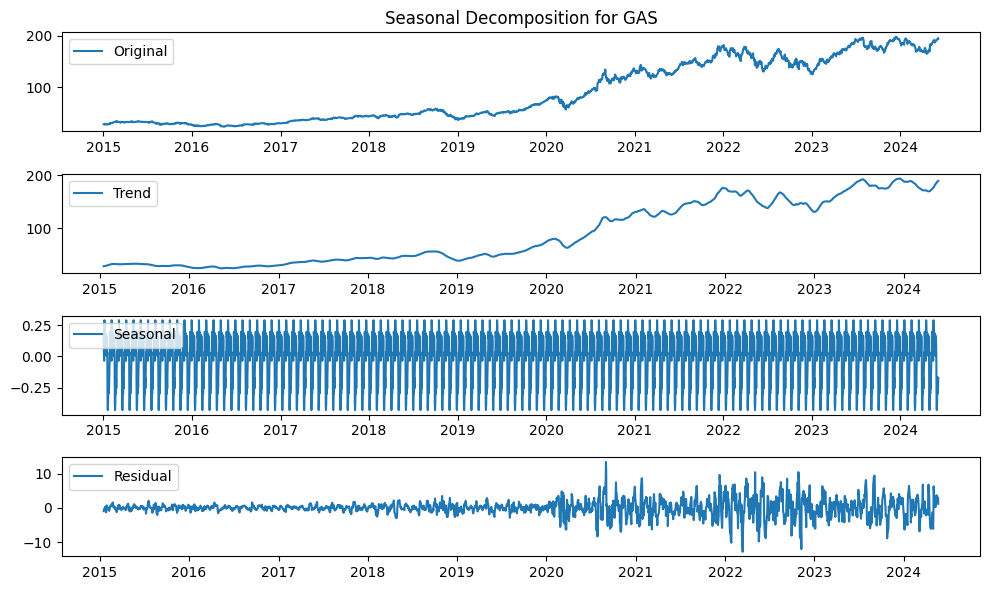

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


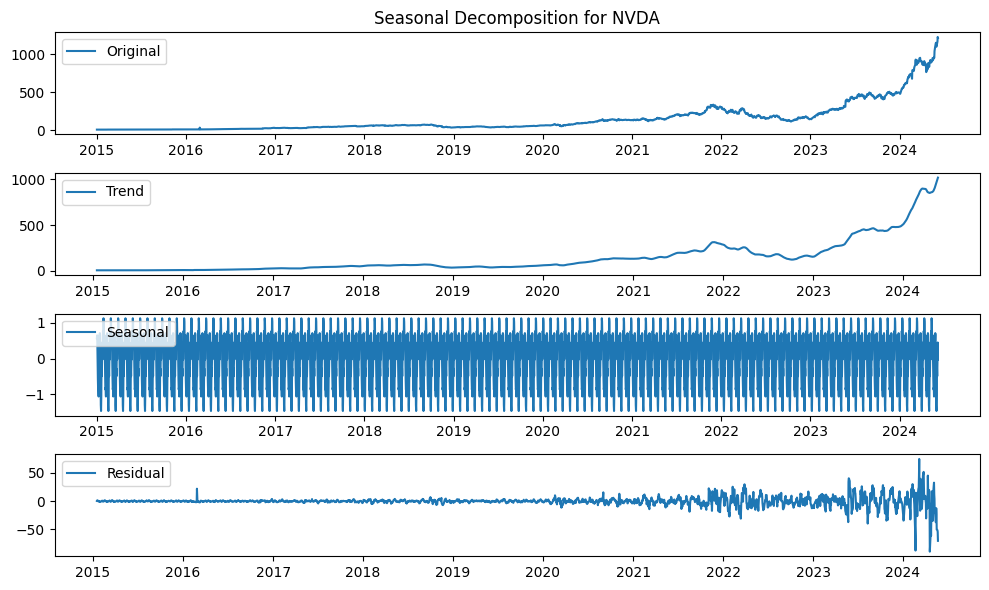

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


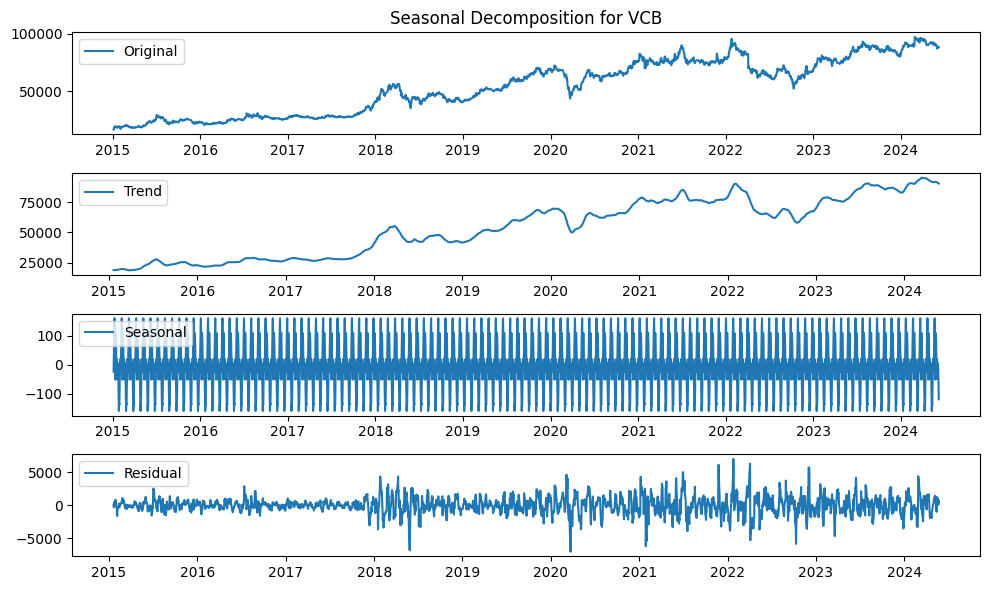

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\2997330920.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


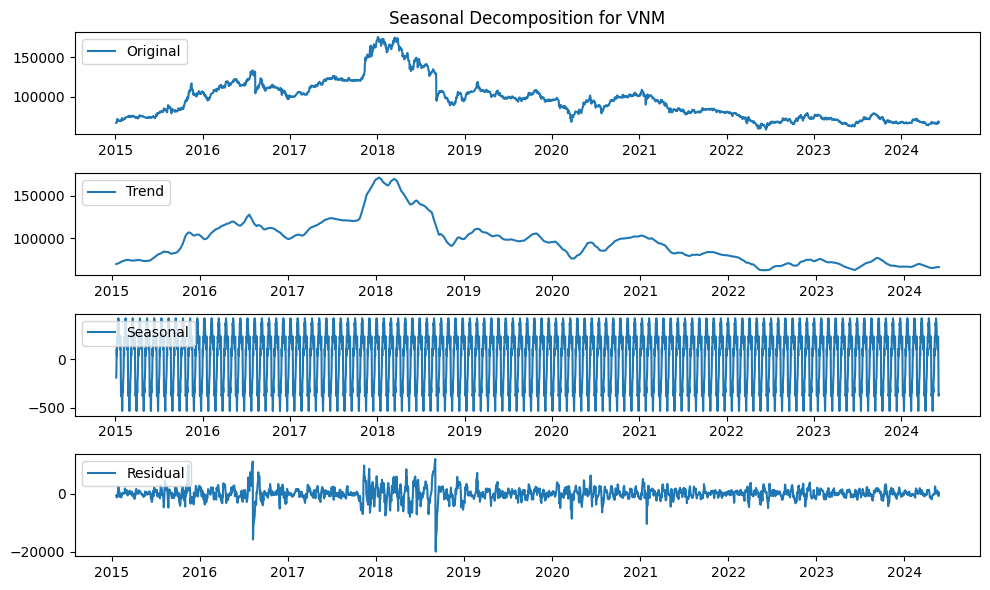

In [11]:
# Perform seasonal decomposition for each stock
for stock in df['Stock_Name'].unique():
    stock_data = df[df['Stock_Name'] == stock].copy()
    stock_data.set_index('Date', inplace=True)
    
    # Ensure daily frequency and interpolate missing values
    stock_data = stock_data.asfreq('D').interpolate()
    
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(stock_data['Price'], model='additive', period=30)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plot the decomposition results
    plt.figure(figsize=(10, 6))
    
    plt.subplot(411)
    plt.plot(stock_data['Price'], label='Original')
    plt.legend(loc='upper left')
    plt.title(f'Seasonal Decomposition for {stock}')
    
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


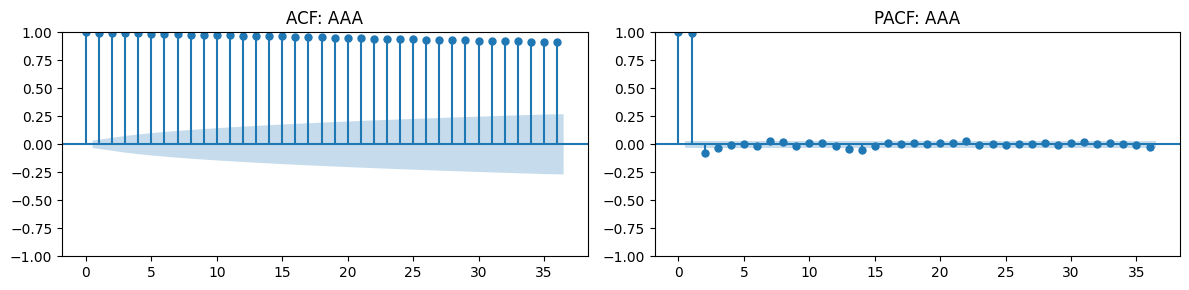

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


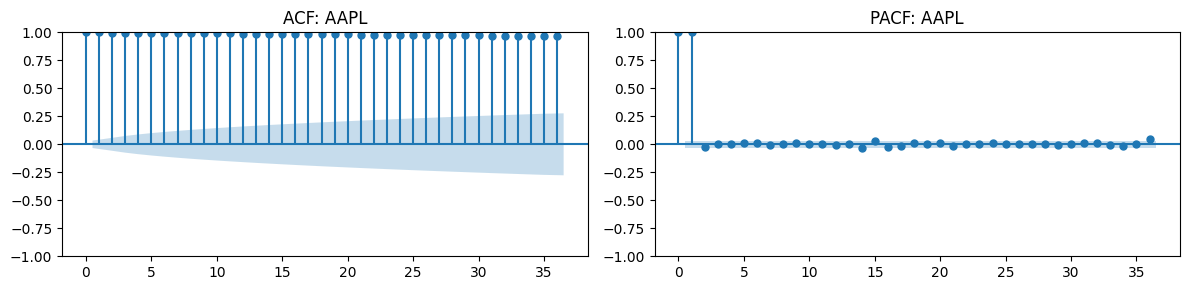

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


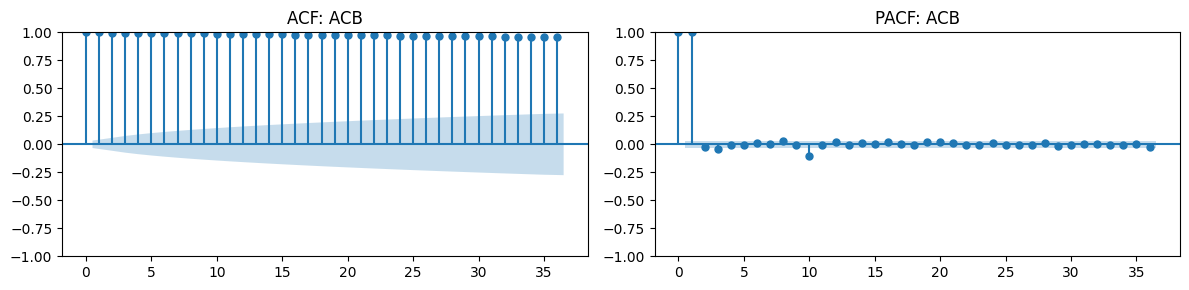

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


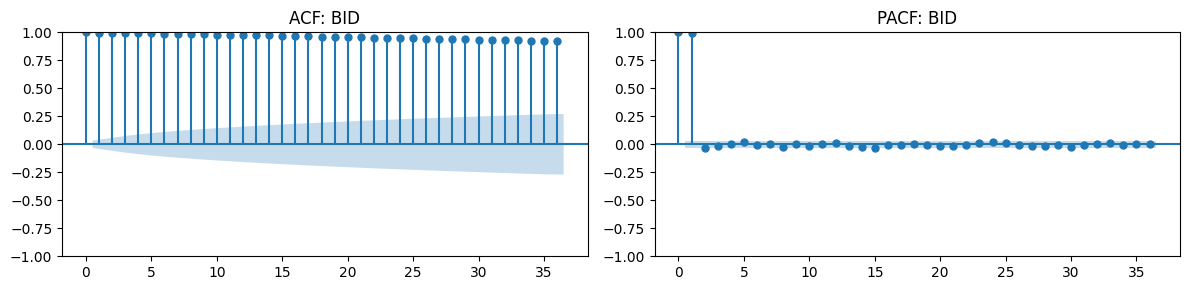

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


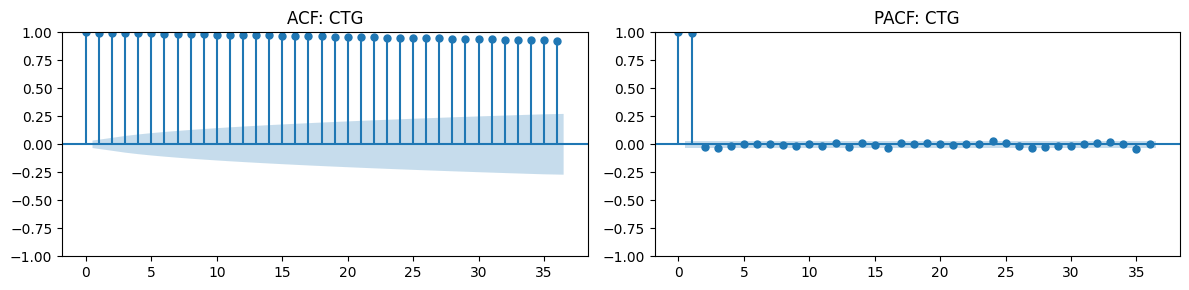

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


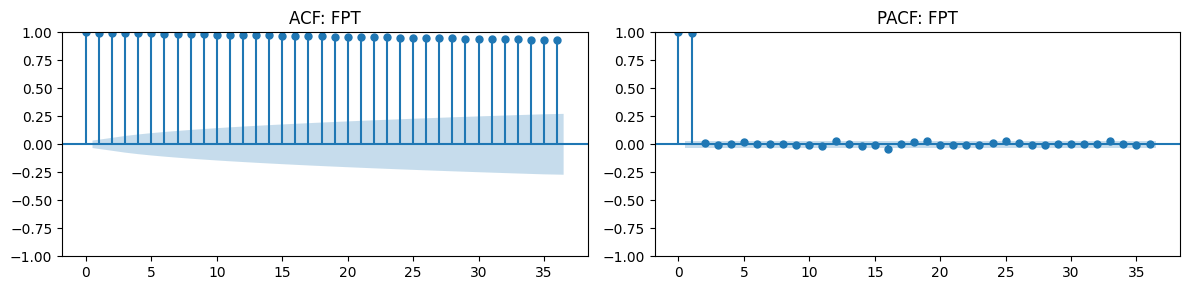

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


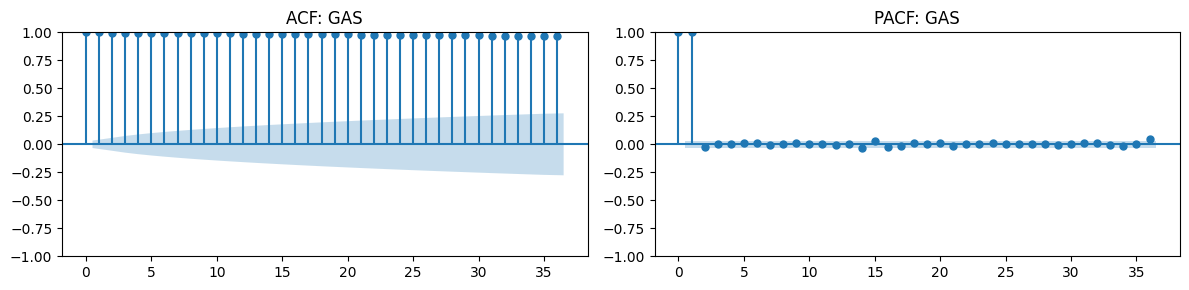

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


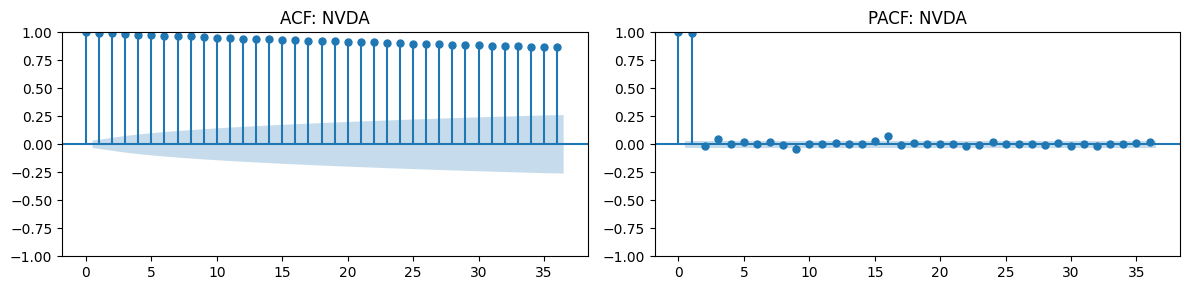

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


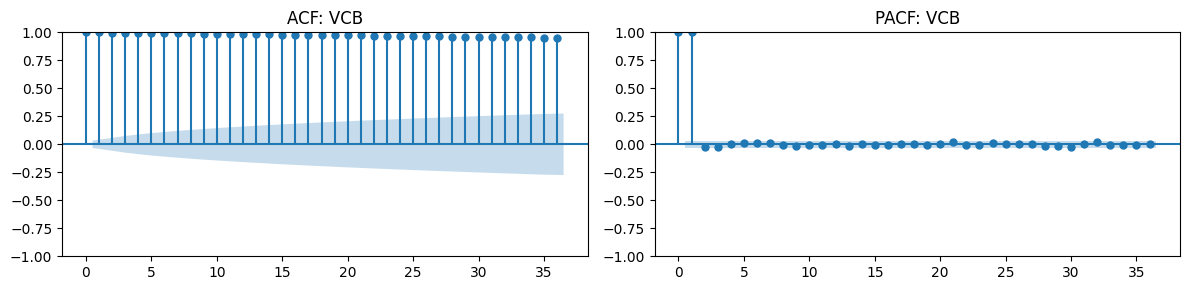

C:\Users\asus\AppData\Local\Temp\ipykernel_19524\943706286.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  stock_data = stock_data.asfreq('D').interpolate()


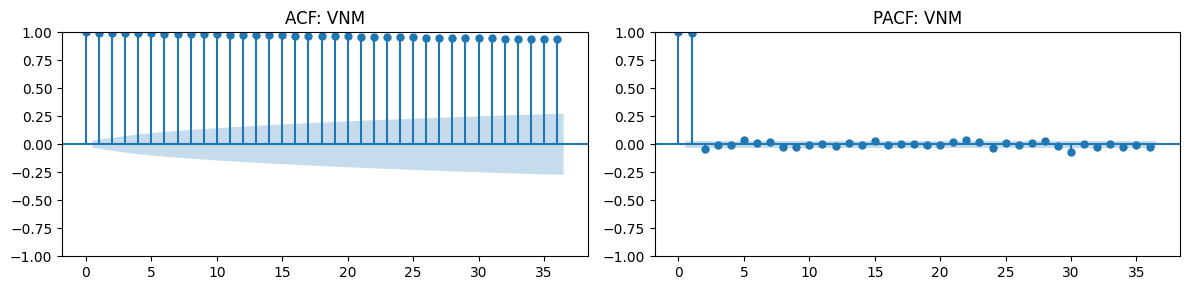

In [12]:
# Perform ACF and PACF plot for each stock
for stock in df['Stock_Name'].unique():
    stock_data = df[df['Stock_Name'] == stock].copy()
    stock_data.set_index('Date', inplace=True)
    
    # Ensure daily frequency and interpolate missing values
    stock_data = stock_data.asfreq('D').interpolate()
    
    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    
    plot_acf(stock_data['Price'], ax=axes[0])
    axes[0].set_title(f'ACF: {stock}')
    
    plot_pacf(stock_data['Price'], ax=axes[1])
    axes[1].set_title(f'PACF: {stock}')
    
    plt.tight_layout()
    plt.show()